In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as td

In [2]:
from dataset import ExtendedYaleFace
from features import *
from classifier import *
from utils import *

## data ##

### original image ###

Original image shape is (192, 168)


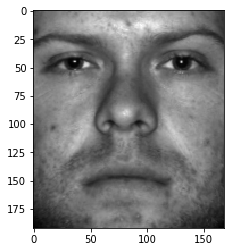

In [3]:
img = Image.open('data/CroppedYale/yaleB01/yaleB01_P00A+000E+00.pgm')
img = np.array(img)
print("Original image shape is", img.shape)
plt.imshow(img, cmap='gray')
plt.show()

### processed image loaded from ExtendedYaleFace dataset ###

Total number of images is 1931
Dimension of the batch data is torch.Size([4, 1, 32, 32])
Batch size is 4
Channel is 1
Image shape is resized to: torch.Size([32, 32])


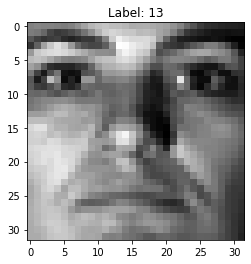

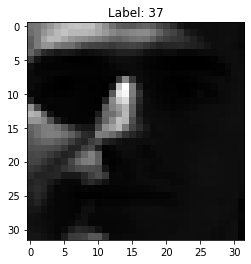

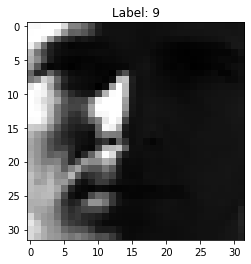

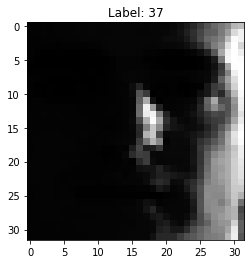

In [4]:
# training dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
print("Total number of images is", train_set.__len__())

# dataloader
train_loader = td.DataLoader(train_set, batch_size=4, shuffle=False)

# visualize the first batch
for batch_idx, (image_batch, labels) in enumerate(train_loader):
    if batch_idx >= 1:
        break
    print("Dimension of the batch data is", image_batch.shape)
    print("Batch size is", image_batch.shape[0])
    print("Channel is", image_batch.shape[1])
    print("Image shape is resized to:", image_batch.shape[2:])
    for img_idx, img in enumerate(image_batch):
        plt.title("Label: %d" % labels[img_idx])
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.show()

### dataset statistics ###

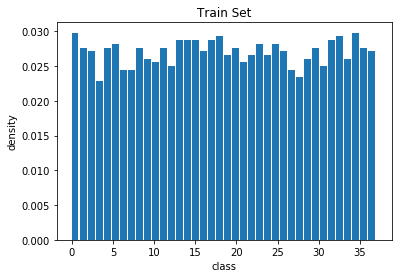

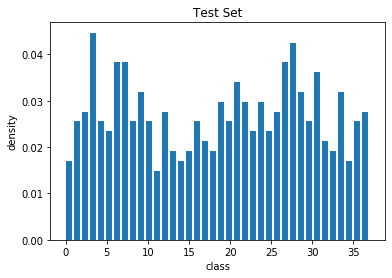

In [5]:
# test dataset (unflattened, normalized to [-1, 1])
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, test=True)

# dataloader
train_loader = td.DataLoader(train_set, batch_size=train_set.__len__(), shuffle=False)
test_loader = td.DataLoader(test_set, batch_size=test_set.__len__(), shuffle=False)

_, y_train = next(iter(train_loader))
plt.hist(y_train, bins=38, density=True, width=0.8)
plt.title("Train Set")
plt.xlabel("class")
plt.ylabel("density")
plt.show()

_, y_test = next(iter(test_loader))
plt.hist(y_test, bins=38, density=True, width=0.8)
plt.title("Test Set")
plt.xlabel("class")
plt.ylabel("density")
plt.show()

## PCA ##

Dimension of the batch data is torch.Size([1931, 1, 1024])


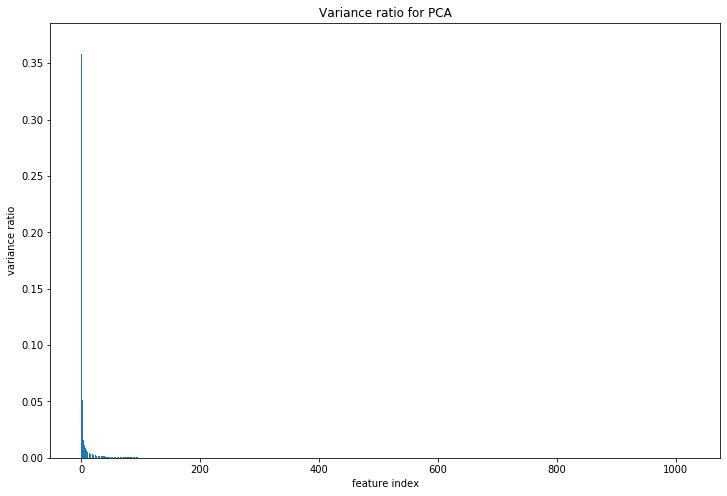

Model saved to models/pca.pkl


In [6]:
# training dataset (flattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, train=True)
pca = pca_fit(train_set)
    
# plot variance ratio
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for PCA")
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

# save and reload model
save_model(pca, "models/pca.pkl")
pca = load_model("models/pca.pkl")

### visualize first 10 eigenfaces ###

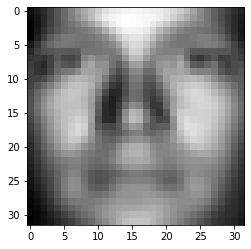

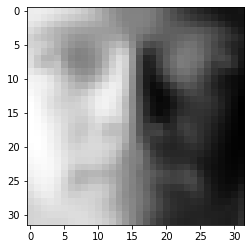

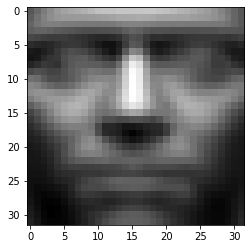

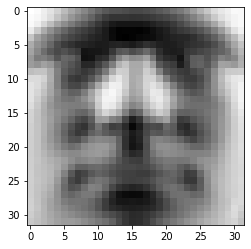

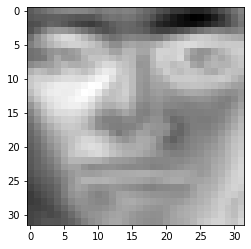

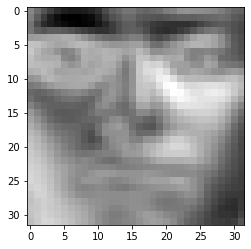

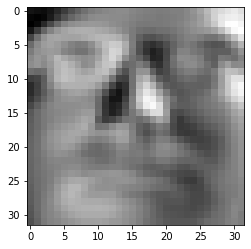

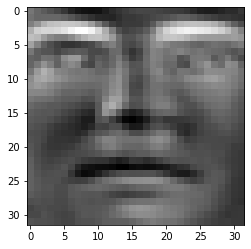

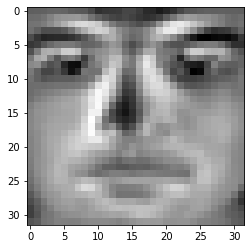

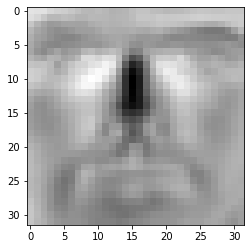

In [7]:
eigenfaces = pca.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.show()

### reconstruct using first 10 basis ###

Dimension of the batch data is torch.Size([483, 1, 1024])


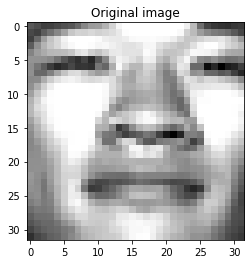

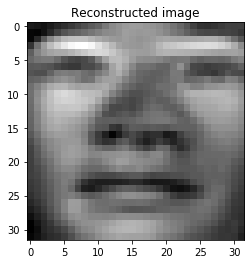

In [8]:
# test dataset (flattened, normalized to [-1, 1])
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, test=True)
X_test_transformed = pca_transform(pca, test_set)

# dataloader
test_loader = td.DataLoader(test_set, batch_size=1, shuffle=False)

# original image
img_original, _ = next(iter(test_loader))
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32), cmap='gray')
plt.show()

# reconstructed image
img_reconstructed = np.zeros((32, 32))
for i in range(10):
    img_reconstructed += X_test_transformed[0, i] * eigenfaces[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

## LBP ##

In [9]:
# training dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)

# dataloader
train_loader = td.DataLoader(train_set, batch_size=1, shuffle=False)

X_train_transformed = lbp_transform(train_set)
print(X_train_transformed.shape)

(1931, 32, 32)


### visualize LBP and corresponding histogram ###

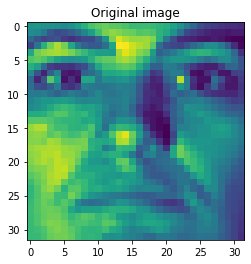

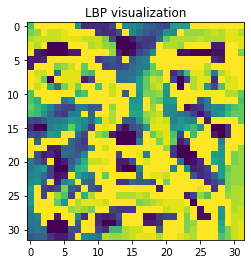

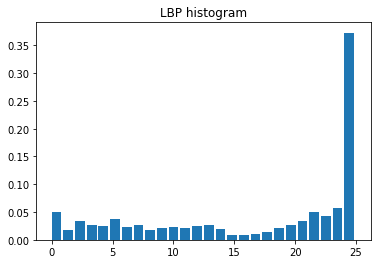

In [10]:
# original image
img_original, _ = next(iter(train_loader))
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy())
plt.show()

# LBP
plt.title("LBP visualization")
plt.imshow(X_train_transformed[0])
plt.show()

# histogram
plt.title("LBP histogram")
plt.hist(X_train_transformed[0].ravel(), bins=int(X_train_transformed.max()+1), density=True, width=0.8)
plt.show()

## HOG ##

In [11]:

# dataset
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
fd_list, hog_images = hog_transform(train_set)
train_loader = td.DataLoader(train_set,batch_size=1, shuffle=False)

### visualize HOG and corresponding histogram ###

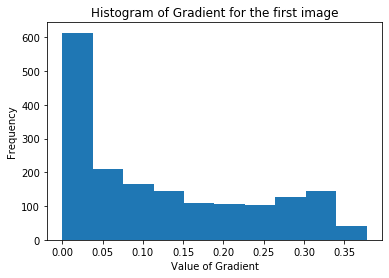

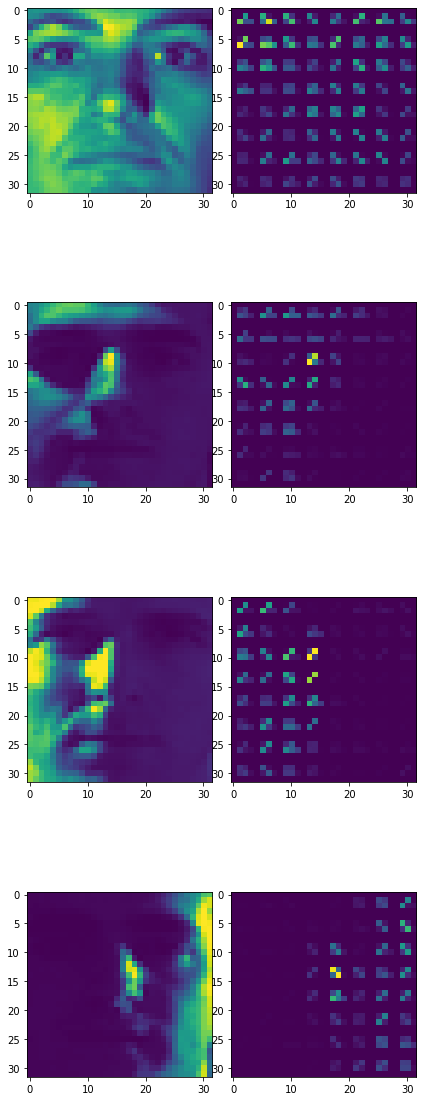

In [12]:
from skimage import exposure

# Histogram for first image
plt.hist(fd_list[0])
plt.title("Histogram of Gradient for the first image")
plt.ylabel("Frequency")
plt.xlabel("Value of Gradient")

plt.show()


# Plot first four image
for i, image in enumerate(train_loader):
    if i == 4:
        break
    plt.subplot(4,2,2*i+1)
    plt.imshow(image[0].squeeze().numpy())
    hog_image_rescale = exposure.rescale_intensity(hog_images[i], in_range=(0, 100))
    plt.subplot(4,2,2*i+2)
    plt.imshow(hog_image_rescale)
plt.subplots_adjust(left=0,top=4, bottom=0, hspace=0.1, wspace=0.1)


# Classifications #

## KNN ##

In [4]:
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, train=True)
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, test=True)
pca = pca_fit(train_set)
X_train_transformed = pca_transform(pca, train_set)
X_test_transformed = pca_transform(pca, test_set)

model_knn = train_knn(X_train_transformed[:, 0:50], train_set.labels)
Y_test_pred = model_knn.predict(X_test_transformed[:, 0:50])
acc = np.mean(Y_test_pred == test_set.labels)
print("Accuracy: %f" % acc)

Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.757764


## ResNet ##

Epoch: 10 | Train Loss: 0.078 | Train Acc: 98.14% | Test Loss: 0.628 | Test Acc: 83.85%
Epoch: 20 | Train Loss: 0.160 | Train Acc: 95.86% | Test Loss: 0.532 | Test Acc: 86.75%
Epoch: 30 | Train Loss: 0.025 | Train Acc: 99.38% | Test Loss: 0.366 | Test Acc: 91.93%
Epoch: 40 | Train Loss: 0.012 | Train Acc: 99.74% | Test Loss: 0.398 | Test Acc: 92.75%
Epoch: 50 | Train Loss: 0.015 | Train Acc: 99.74% | Test Loss: 0.442 | Test Acc: 90.89%
Epoch: 60 | Train Loss: 0.009 | Train Acc: 99.74% | Test Loss: 0.374 | Test Acc: 92.55%
Epoch: 70 | Train Loss: 0.010 | Train Acc: 99.69% | Test Loss: 0.404 | Test Acc: 92.13%
Epoch: 80 | Train Loss: 0.012 | Train Acc: 99.79% | Test Loss: 0.391 | Test Acc: 92.34%
Epoch: 90 | Train Loss: 0.008 | Train Acc: 99.84% | Test Loss: 0.393 | Test Acc: 92.55%
Epoch: 100 | Train Loss: 0.008 | Train Acc: 99.90% | Test Loss: 0.385 | Test Acc: 92.55%


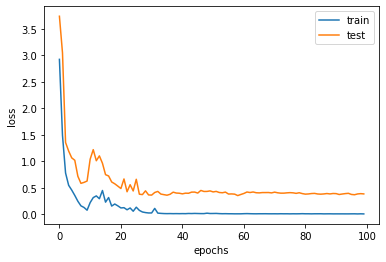

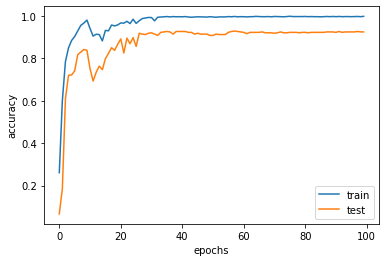

Model saved to models/resnet.pth


In [13]:
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, test=True)
model_resnet = train_resnet(train_set, test_set)

# save and reload model
save_model(model_resnet, "models/resnet.pth")
model_resnet = load_model("models/resnet.pth")